In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# `py` ABC

In [2]:
from abc_sir import *

In [4]:
# Set random seed for reproducibility.
np.random.seed(42)

ndays = 600
N = 1000

# Create a mock dataset using fiducial parameters.
fiducial_beta = 0.1
fiducial_gamma = 0.01
observed_S, observed_I, observed_R = simulator(fiducial_beta, fiducial_gamma, ndays, N)
observed_data = np.array([observed_S, observed_I, observed_R], ndmin=2)

# Initialize the ABC SIR object.
# To use fixed epsilon, set epsilon_fixed to a value.
# For 75th percentile rule, leave epsilon_fixed as None.
abc = ABCSIR(observed=observed_data, exponent_scale=0.1, beta_a=1e-2, beta_b=1,
                 simulator_func=simulator, distance_func=distance,
                 ndays=ndays, N=N, n_iterations=10_000, epsilon_fixed=20)
abc.run()

# Save results (the .npz file contains S, R, I, epsilon arrays)
# abc.save_results('/home/ubuntu/iti/data/abc_sir_results.npz')

# Plotting
plot_histograms(abc.accepted_betas, abc.accepted_gammas, fiducial_beta, fiducial_gamma)
# if abc.epsilon_fixed is None and len(abc.epsilon_history) > 0:
#     plot_epsilon_update(abc.epsilon_history)
# plot_trace(abc.accepted_betas, abc.accepted_gammas, fiducial_beta, fiducial_gamma)

d_S: 3.292, d_I: 20.107, d_R: 19.746
d_S: 3.239, d_I: 19.617, d_R: 19.746
d_S: 0.747, d_I: 19.709, d_R: 19.746
d_S: 4.902, d_I: 20.442, d_R: 19.746
d_S: 19.528, d_I: 7.369, d_R: 19.746
d_S: 6.155, d_I: 19.332, d_R: 19.746
d_S: 5.988, d_I: 20.731, d_R: 19.746
d_S: 21.729, d_I: 6.233, d_R: 19.746
d_S: 5.356, d_I: 20.556, d_R: 19.746
d_S: 1.511, d_I: 19.867, d_R: 19.746
d_S: 1.139, d_I: 19.830, d_R: 19.746
d_S: 3.371, d_I: 20.120, d_R: 19.746
d_S: 0.309, d_I: 1.725, d_R: 1.762
d_S: 0.441, d_I: 19.716, d_R: 19.746
d_S: 4.901, d_I: 20.441, d_R: 19.746
d_S: 2.467, d_I: 19.978, d_R: 19.746
d_S: 3.116, d_I: 6.754, d_R: 5.970
d_S: 20.100, d_I: 7.151, d_R: 19.746
d_S: 5.654, d_I: 19.367, d_R: 19.746
d_S: 15.110, d_I: 13.272, d_R: 19.746
d_S: 5.217, d_I: 19.458, d_R: 19.746
d_S: 3.953, d_I: 19.559, d_R: 19.746
d_S: 2.762, d_I: 19.658, d_R: 19.746
d_S: 0.676, d_I: 19.701, d_R: 19.746
d_S: 17.139, d_I: 10.334, d_R: 19.746
d_S: 11.596, d_I: 16.602, d_R: 19.746
d_S: 8.225, d_I: 18.781, d_R: 19.746
d_

KeyboardInterrupt: 

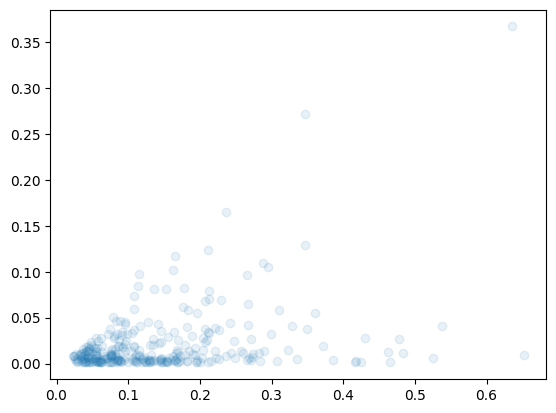

In [5]:
plt.plot(abc.accepted_betas, abc.accepted_gammas, 'o', alpha=0.1)

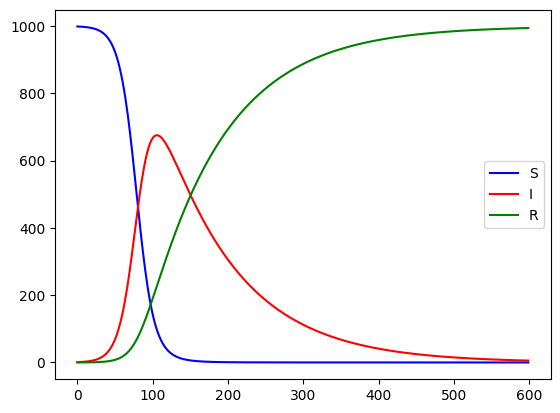

In [95]:
plt.plot(observed_S, label='S', color='blue')
plt.plot(observed_I, label='I', color='red')
plt.plot(observed_R, label='R', color='green')
plt.legend()
plt.show()

# `py` SMC-ABC

In [2]:
from smc_abc_sir import *

Running Generation 0 ...
Generation 0: epsilon = 46.71008
Running Generation 1 ...
Generation 1: epsilon = 28.39933
Running Generation 2 ...
Generation 2: epsilon = 16.70107
Running Generation 3 ...
Generation 3: epsilon = 13.26391
Running Generation 4 ...
Generation 4: epsilon = 11.13647
Time taken: 151.15 seconds


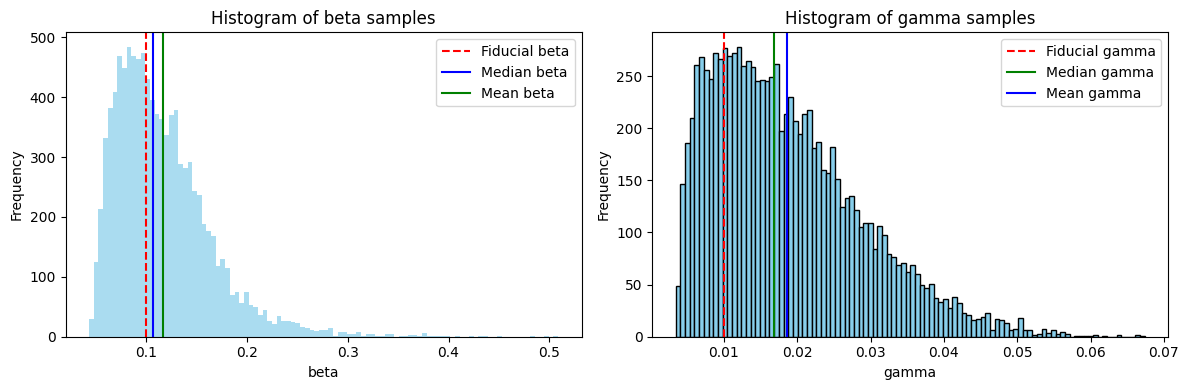

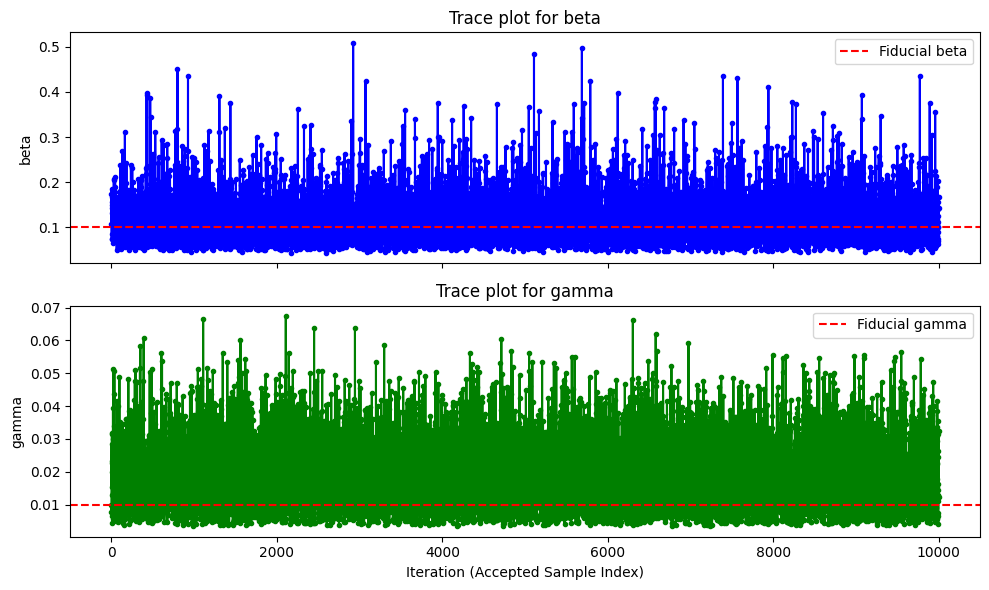

In [3]:
np.random.seed(42)
    
ndays = 600
N = 1000

# Create a mock dataset using fiducial parameters.
fiducial_beta = 0.1
fiducial_gamma = 0.01
observed_S, observed_I, observed_R = simulator(fiducial_beta, fiducial_gamma, ndays, N)
observed_data = np.array([observed_S, observed_I, observed_R], ndmin=2)

# Initialize and run the ABC SMC algorithm.
abc_smc = ABCSMC(observed=observed_data, exponent_scale=0.1, beta_a=1e-2, beta_b=1,
                    simulator_func=simulator, distance_func=distance,
                    ndays=ndays, N=N, n_generations=5, population_size=10_000)
abc_smc.run()

# Save results.
# abc_smc.save_results('/home/ubuntu/iti/project/abc_smc_results.npz')

# Plotting.
plot_histograms(abc_smc.accepted_betas, abc_smc.accepted_gammas, fiducial_beta, fiducial_gamma)
plot_trace(abc_smc.accepted_betas, abc_smc.accepted_gammas, fiducial_beta, fiducial_gamma)

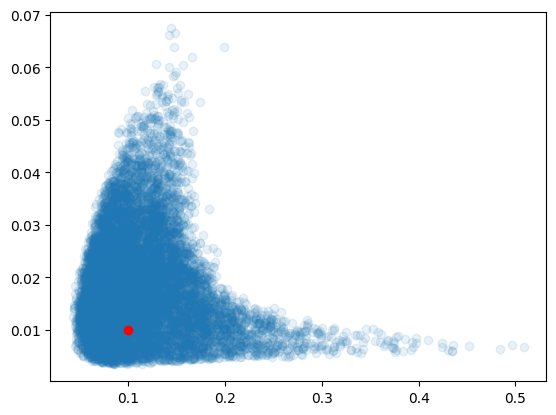

In [4]:
plt.plot(abc_smc.accepted_betas, abc_smc.accepted_gammas, 'o', alpha=0.1)
plt.plot(fiducial_beta, fiducial_gamma, 'o', color='red')

# `C` ABC

In [14]:
import pandas as pd
data_c = pd.read_csv('/home/ubuntu/iti/project/C/abc_data/abc_10k_18.csv')

In [15]:
data_c.shape

(10000, 2)

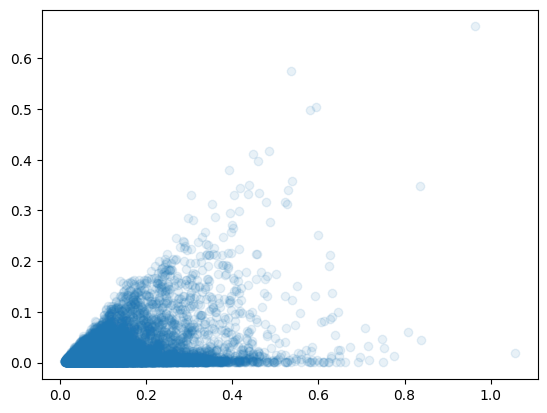

In [16]:
plt.plot(data_c['beta'], data_c['gamma'], 'o', alpha=0.1)

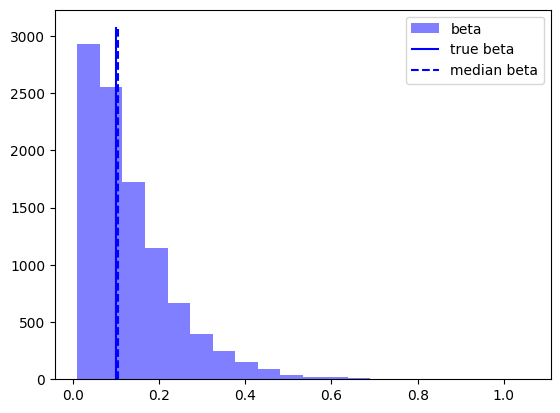

In [17]:
plt.hist(data_c['beta'], bins=20, alpha=0.5, color='blue', label='beta')
ymin, ymax = plt.ylim()
plt.vlines(0.1, ymin, ymax, color='blue', label='true beta')
plt.vlines(np.median(data_c['beta']), ymin, ymax, color='blue', linestyle='dashed', label='median beta')
plt.legend()
plt.show()

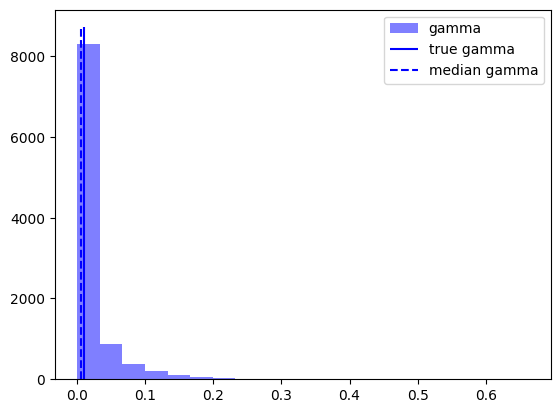

In [18]:
plt.hist(data_c['gamma'], bins=20, alpha=0.5, color='blue', label='gamma')
ymin, ymax = plt.ylim()
plt.vlines(0.01, ymin, ymax, color='blue', label='true gamma')
plt.vlines(np.median(data_c['gamma']), ymin, ymax, color='blue', linestyle='dashed', label='median gamma')
plt.legend()
plt.show()

# `C` ABC-SMC

In [3]:
data_cc = pd.read_csv('/home/ubuntu/iti/project/C/abc_smc.csv')

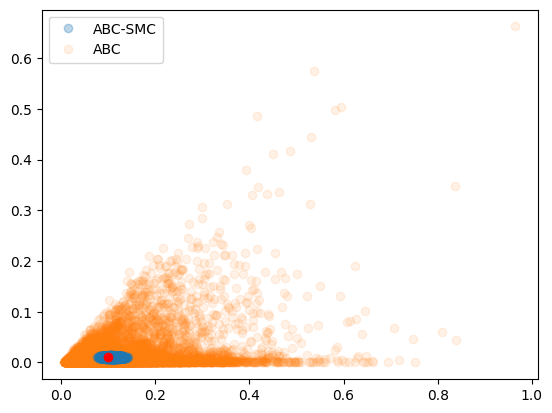

In [5]:
plt.plot(data_cc['beta'], data_cc['gamma'], 'o', alpha=0.3, label='ABC-SMC', zorder=100)
plt.plot(data_c['beta'], data_c['gamma'], 'o', alpha=0.1, label='ABC')
plt.plot(0.1, 0.01, 'o', color='red', zorder=100)
plt.legend()

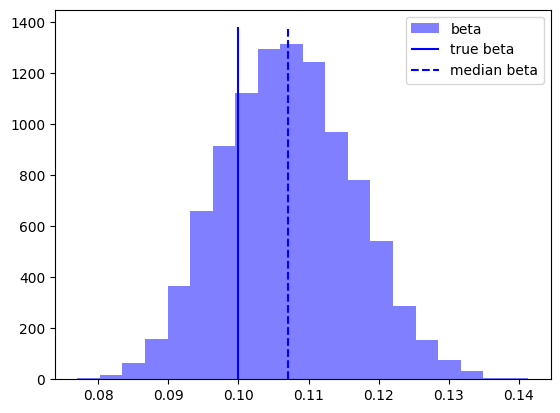

In [6]:
plt.hist(data_cc['beta'], bins=20, alpha=0.5, color='blue', label='beta')
ymin, ymax = plt.ylim()
plt.vlines(0.1, ymin, ymax, color='blue', label='true beta')
plt.vlines(np.median(data_cc['beta']), ymin, ymax, color='blue', linestyle='dashed', label='median beta')
plt.legend()
plt.show()

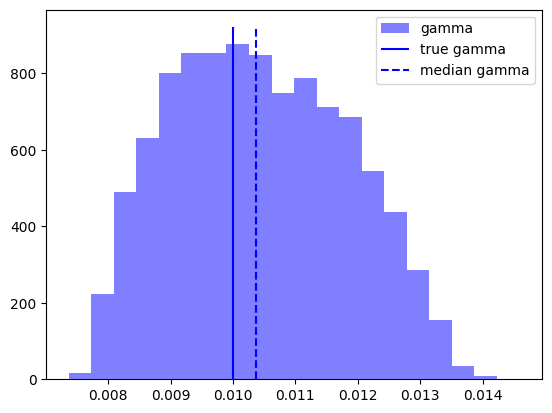

In [7]:
plt.hist(data_cc['gamma'], bins=20, alpha=0.5, color='blue', label='gamma')
ymin, ymax = plt.ylim()
plt.vlines(0.01, ymin, ymax, color='blue', label='true gamma')
plt.vlines(np.median(data_cc['gamma']), ymin, ymax, color='blue', linestyle='dashed', label='median gamma')
plt.legend()
plt.show()

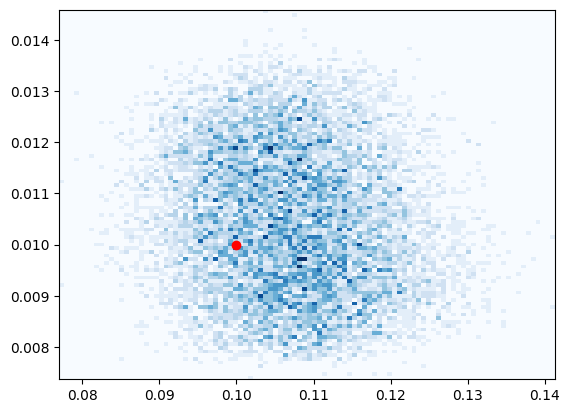

In [8]:
plt.hist2d(data_cc['beta'], data_cc['gamma'], bins=int(np.sqrt(len(data_cc['beta']))), cmap='Blues')
plt.plot(0.1, 0.01, 'o', color='red')
plt.show()

In [32]:
path = "/home/ubuntu/iti/project/C/smc_data/"

gen_1 = pd.read_csv(path + '/abc_smc_gen_1.csv')
gen_2 = pd.read_csv(path + '/abc_smc_gen_2.csv')
gen_3 = pd.read_csv(path + '/abc_smc_gen_3.csv')
gen_4 = pd.read_csv(path + '/abc_smc_gen_4.csv')
gen_5 = pd.read_csv(path + '/abc_smc_gen_5.csv')
gen_6 = pd.read_csv(path + '/abc_smc_gen_6.csv')
gen_7 = pd.read_csv(path + '/abc_smc_gen_7.csv')
gen_8 = pd.read_csv(path + '/abc_smc_gen_8.csv')
gen_9 = pd.read_csv(path + '/abc_smc_gen_9.csv')
gen_10 = pd.read_csv(path + '/abc_smc_gen_10.csv')

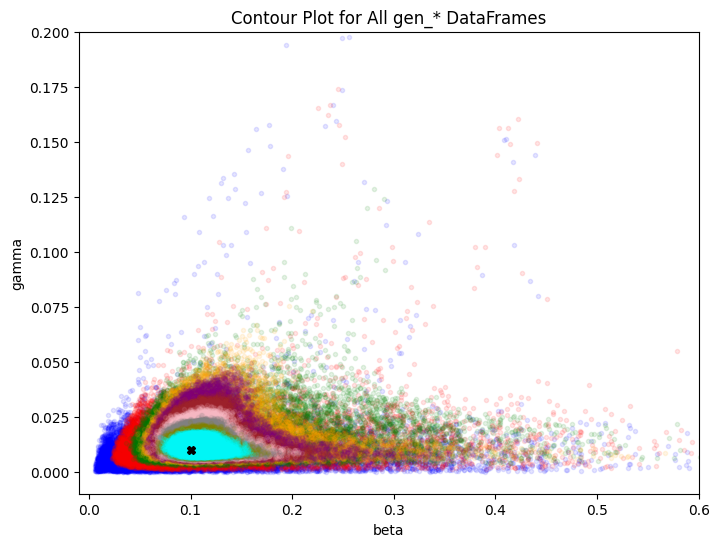

In [33]:
import scipy.stats as st

gens = [gen_1, gen_2, gen_3, gen_4, gen_5, gen_6, gen_7, gen_8, gen_9, gen_10]
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

fig, ax = plt.subplots(figsize=(8, 6))

for i, gen in enumerate(gens):
    beta = gen['beta'].values
    gamma = gen['gamma'].values
    plt.scatter(beta, gamma, marker='.', color=colors[i], alpha=0.1)

plt.plot(0.1, 0.01, 'X', color='black', label='True Parameters')
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
ax.set_title('Contour Plot for All gen_* DataFrames')
ax.set_xlim(-0.01, 0.6)
ax.set_ylim(-0.01, 0.2)
plt.show()

(-0.01, 0.2)

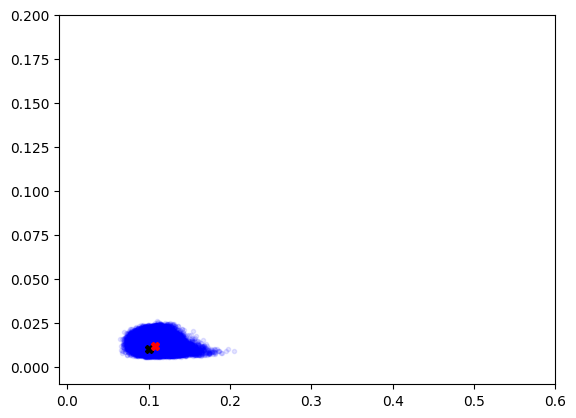

In [56]:
plt.scatter(gen_8['beta'], gen_8['gamma'], marker='.', color='blue', alpha=0.1)
plt.plot(0.1, 0.01, 'X', color='black', label='True Parameters')
plt.plot(np.median(gen_10['beta']), np.median(gen_10['gamma']), 'X', color='red', label='Median Parameters')
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
ax.set_title('Contour Plot for All gen_* DataFrames')
plt.xlim(-0.01, 0.6)
plt.ylim(-0.01, 0.2)

(-0.01, 0.2)

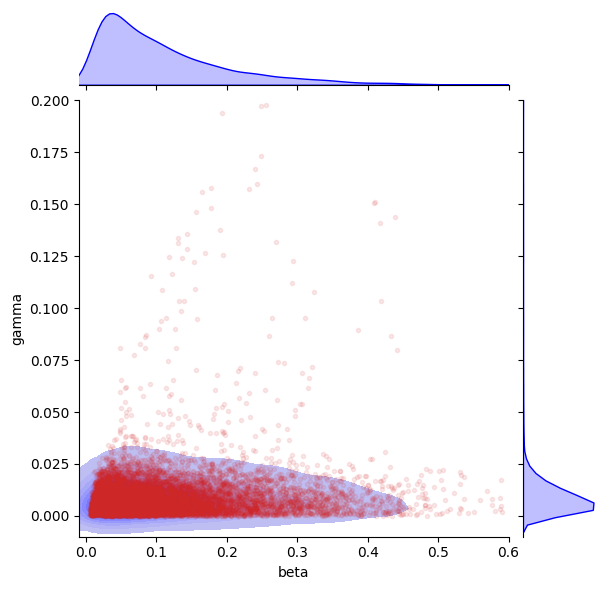

In [14]:
# for i, gen in enumerate(gens):
sns.jointplot(x='beta', y='gamma', data=gens[0], kind='kde', color=colors[0], fill=True)
plt.scatter(gens[0]['beta'], gens[0]['gamma'], marker='.', color='tab:red', alpha=0.1)
plt.xlim(-0.01, 0.6)
plt.ylim(-0.01, 0.2)

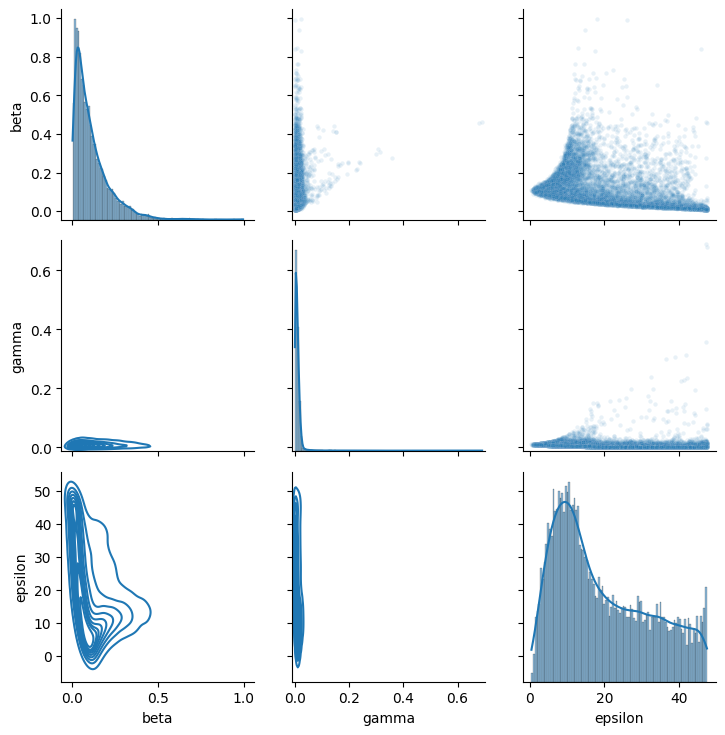

In [29]:
df = gens[0][['beta', 'gamma']]
g = sns.PairGrid(gens[0], diag_sharey=False)
g.map_upper(sns.scatterplot, s=10, alpha=0.1)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot, bins=100, kde=True)
# plt.xlim(-0.01, 0.6)
# plt.ylim(-0.01, 0.2)

/tmp/ipykernel_151780/1462869914.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


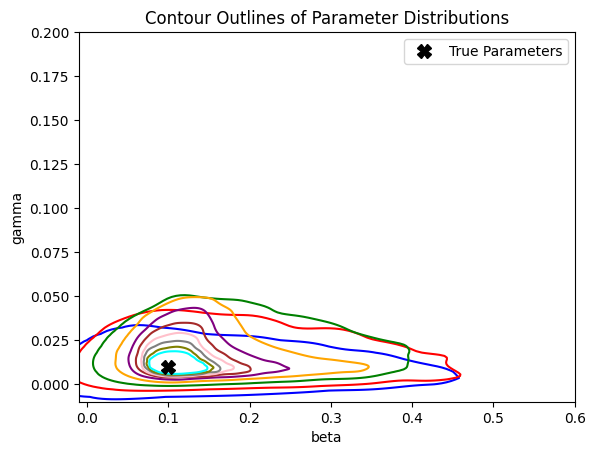

In [34]:
# Create a contour plot of the 2D distribution
for i, gen in enumerate(gens):
    sns.kdeplot(data=gen, x='beta', y='gamma', levels=[0.05], 
                color=colors[i], label=f'Generation {i+1}')
plt.legend()

plt.plot(0.1, 0.01, 'X', color='black', label='True Parameters', markersize=10)
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('Contour Outlines of Parameter Distributions')
plt.xlim(-0.01, 0.6)
plt.ylim(-0.01, 0.2)
plt.legend()
plt.show()

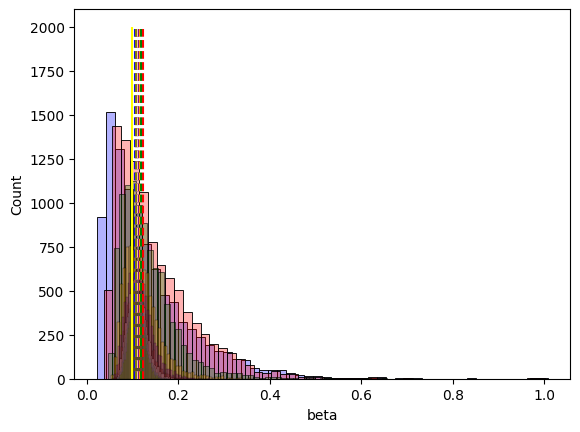

In [46]:
gens = [gen_2, gen_3, gen_4, gen_5, gen_6, gen_7, gen_8, gen_9, gen_10]

for i, gen in enumerate(gens):
    sns.histplot(data=gen, x='beta', bins=50,
                color=colors[i], label=f'Generation {i+1}', alpha=0.3)
    plt.vlines(np.median(gen['beta']), 0, 2000, color=colors[i], linestyle='dashed')
plt.vlines(0.1, 0, 2000, color='yellow', label='True beta')

In [50]:
import matplotlib.animation as animation

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

def update(frame):
    ax.clear()
    gen = gens[frame]
    
    # Plot histogram
    sns.histplot(data=gen, x='beta', bins=50, ax=ax, color='mediumseagreen')
    
    # Add vertical lines for true value and median
    ax.axvline(x=0.1, color='red', linestyle='solid', label='True Beta')
    ax.axvline(x=np.median(gen['beta']), color='black', linestyle='dashed', label='Median')
    
    # Set title and labels
    ax.set_title(f'Generation {frame + 1}')
    ax.set_xlabel('Beta')
    ax.set_ylabel('Count')
    ax.legend()
    
    # Set consistent x and y limits
    ax.set_xlim(0, 0.4)
    ax.set_ylim(0, 1750)

# Create the animation
anim = animation.FuncAnimation(fig, update, frames=len(gens), 
                               repeat=True, interval=3000)

# Save as GIF
anim.save(path+'beta_evolution.gif', writer='pillow')
plt.close()

In [71]:
import matplotlib.animation as animation
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

def update(frame):
    ax.clear()
    gen = gens[frame]
    
    # Plot histogram
    ax.hist(gen['gamma'], color='mediumseagreen', density=False, edgecolor='black')
    
    # Add vertical lines for true value and median
    ax.axvline(x=0.01, color='red', linestyle='solid', label='True Beta')
    ax.axvline(x=np.median(gen['gamma']), color='black', linestyle='dashed', label='Median')
    
    # Set title and labels
    ax.set_title(f'Generation {frame + 1}')
    ax.set_xlabel('Gamma')
    ax.set_ylabel('Count')
    ax.legend()
    
    # Set consistent x and y limits
    ax.set_xlim(-0.01, 0.2)
    # ax.set_ylim(0, 4000)

# Create the animation
anim = animation.FuncAnimation(fig, update, frames=len(gens), 
                               repeat=True, interval=3000)

# Save as GIF
anim.save(path+'gamma_evolution.gif', writer='pillow')
plt.close()

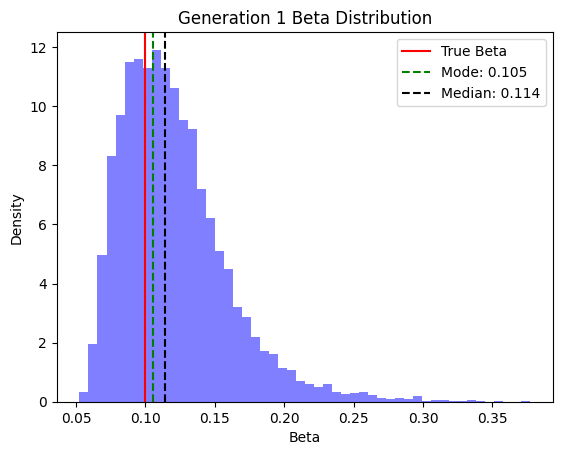

In [74]:
# Create histogram of gen_1's beta values
plt.hist(gen_5['beta'], bins=50, color='blue', alpha=0.5, density=True)

# Find the mode of the distribution (maximum point of KDE)
kde = st.gaussian_kde(gen_5['beta'])
x_range = np.linspace(gen_5['beta'].min(), gen_5['beta'].max(), 1000)
mode_x = x_range[np.argmax(kde(x_range))]

# Plot vertical lines
plt.axvline(x=0.1, color='red', linestyle='solid', label='True Beta')
plt.axvline(x=mode_x, color='green', linestyle='dashed', label=f'Mode: {mode_x:.3f}')
plt.axvline(x=np.median(gen_5['beta']), color='black', linestyle='dashed', label=f'Median: {np.median(gen_5["beta"]):.3f}')

plt.xlabel('Beta')
plt.ylabel('Density')
plt.title('Generation 1 Beta Distribution')
plt.legend()
plt.show()

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))

def update(frame):
    ax.clear()
    gen = gens[frame]
    
    ax.hist(gen['beta'], bins=50, color='blue', alpha=0.5, density=True)

    # Find the mode of the distribution (maximum point of KDE)
    kde = st.gaussian_kde(gen['beta'])
    x_range = np.linspace(gen['beta'].min(), gen['beta'].max(), 1000)
    mode_x = x_range[np.argmax(kde(x_range))]

    # Plot vertical lines
    plt.axvline(x=0.1, color='red', linestyle='solid', label='True Beta')
    plt.axvline(x=mode_x, color='green', linestyle='dashed', label=f'Mode: {mode_x:.3f}')
    plt.axvline(x=np.median(gen['beta']), color='black', linestyle='dashed', label=f'Median: {np.median(gen["beta"]):.3f}')

    plt.xlabel('Beta')
    plt.ylabel('Density')
    plt.title(f'Generation {frame + 1}')
    plt.legend()

# Create the animation
anim = animation.FuncAnimation(fig, update, frames=len(gens), 
                               repeat=True, interval=3000)

# Save as GIF
anim.save(path+'beta_evolution.gif', writer='pillow')
plt.close()